In [2]:
# ============== PART 1: IMPORTS ==============
import pandas as pd
import numpy as np
import re
import nltk

# Import necessary NLTK components
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# It's good practice to run the downloads again in a new notebook
# NLTK is smart and won't re-download if the data already exists.
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('omw-1.4') # Open Multilingual Wordnet, a dependency for WordNet

# ============== PART 2: DATA LOADING ==============
# Define the file path
file_path = "../data/Womens Clothing E-Commerce Reviews.csv"

# Load the CSV file into a pandas DataFrame
# We drop the first unnamed column which is just an index from the original CSV
df = pd.read_csv(file_path, index_col=0)


# ============== PART 3: INITIAL DATA CLEANING ==============
# Drop rows where 'Review Text' is missing
df.dropna(subset=['Review Text'], inplace=True)

# Filter out neutral reviews (Rating = 3) to create a binary problem
df = df[df['Rating'] != 3].copy() # Use .copy() to avoid SettingWithCopyWarning

# Create the 'sentiment' column (1 for Positive, 0 for Negative)
df['sentiment'] = df['Rating'].apply(lambda rating: 1 if rating > 3 else 0)


# ============== PART 4: TEXT PREPROCESSING FUNCTION ==============
# Initialize the lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Cleans and preprocesses a single text string.
    """
    # 1. Lowercasing
    text = text.lower()
    
    # 2. Removing punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 3. Tokenization
    tokens = word_tokenize(text)
    
    # 4. Removing stopwords and Lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
            
    # 5. Join tokens back into a single string
    return " ".join(cleaned_tokens)


# ============== PART 5: APPLYING THE PREPROCESSING ==============
# Apply the function to the 'Review Text' column. This may take a moment.
print("Starting text preprocessing...")
df['cleaned_text'] = df['Review Text'].apply(preprocess_text)
print("Text preprocessing complete!")


# ============== PART 6: VERIFY THE RESULT ==============
# Display the first few rows with the key columns to verify everything worked
print("\nDataFrame is ready for advanced modeling:")
print(df[['cleaned_text', 'sentiment']].head())

Starting text preprocessing...
Text preprocessing complete!

DataFrame is ready for advanced modeling:
                                        cleaned_text  sentiment
0        absolutely wonderful silky sexy comfortable          1
1  love dress sooo pretty happened find store im ...          1
3  love love love jumpsuit fun flirty fabulous ev...          1
4  shirt flattering due adjustable front tie perf...          1
5  love tracy reese dress one petite foot tall us...          0


In [3]:
tokenized_text = df['cleaned_text'].apply(lambda x: x.split())
print(tokenized_text.head())

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happened, find, st...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
5    [love, tracy, reese, dress, one, petite, foot,...
Name: cleaned_text, dtype: object


In [7]:
from gensim.models import Word2Vec

embedding_dim = 100
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=embedding_dim,window=5,min_count=5,workers=4)

print("Words most similar to 'dress':")
print(w2v_model.wv.most_similar('dress'))

print("\nWords most similar to 'soft':")
print(w2v_model.wv.most_similar('soft'))

print("\nVector for the word 'fabric':")
print(w2v_model.wv['fabric'])

Words most similar to 'dress':
[('top', 0.5568280220031738), ('absolutely', 0.5246739983558655), ('jumpsuit', 0.5213248133659363), ('skirt', 0.4894891083240509), ('soooooo', 0.4612273871898651), ('blouse', 0.4599113166332245), ('pre', 0.4517476260662079), ('puttogether', 0.44825366139411926), ('elegantly', 0.4435317814350128), ('sassy', 0.4405764043331146)]

Words most similar to 'soft':
[('lightweight', 0.7620058655738831), ('stretchy', 0.7532396912574768), ('thick', 0.7480956315994263), ('breathable', 0.7245926856994629), ('substantial', 0.7206012010574341), ('gauzy', 0.7146739363670349), ('silky', 0.714089035987854), ('cozy', 0.6968247890472412), ('light', 0.6895396709442139), ('airy', 0.6814002394676208)]

Vector for the word 'fabric':
[-0.09714934 -1.4307705   0.3158937   0.4966538  -0.39687115  0.36040026
  0.6694618   0.5325762   0.17154475 -0.62310237 -0.91199905 -0.6356387
 -0.8476426  -0.99096817 -0.03332862 -0.71500605 -1.122482   -1.2874366
  0.2260227  -1.4269211  -0.19902

In [9]:
import numpy as np

def vectorize_document(doc,model):

    word_vectors = [model.wv[word] for word in doc if word in model.wv.key_to_index]

    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)
from sklearn.model_selection import train_test_split

X = tokenized_text
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

X_train_vec = np.array([vectorize_document(doc, w2v_model) for doc in X_train])
X_test_vec = np.array([vectorize_document(doc,w2v_model) for doc in X_test])

print("Shape of training vectors:", X_train_vec.shape)
print("Shape of testing vectors:", X_test_vec.shape)

Shape of training vectors: (15854, 100)
Shape of testing vectors: (3964, 100)


Training model with Word2Vec features...
Training complete!

--- Classification Report (Word2Vec) ---
              precision    recall  f1-score   support

           0       0.75      0.42      0.54       478
           1       0.92      0.98      0.95      3486

    accuracy                           0.91      3964
   macro avg       0.84      0.70      0.74      3964
weighted avg       0.90      0.91      0.90      3964



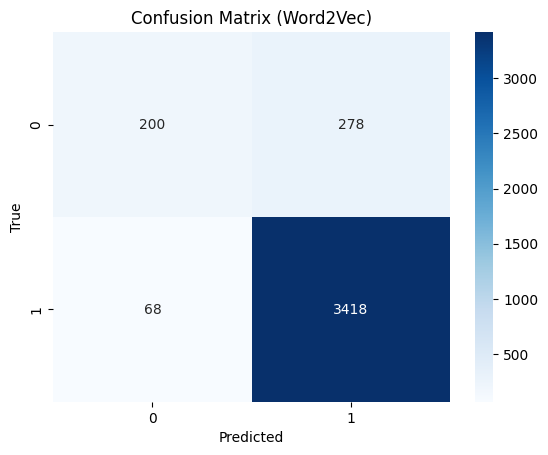

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lr_model_w2v = LogisticRegression()
print("Training model with Word2Vec features...")
lr_model_w2v.fit(X_train_vec, y_train)
print("Training complete!")

y_pred_w2v = lr_model_w2v.predict(X_test_vec)

print("\n--- Classification Report (Word2Vec) ---")
print(classification_report(y_test,y_pred_w2v))

cm = confusion_matrix(y_test,y_pred_w2v)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Word2Vec)')
plt.show()

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 10000
MAX_LEN = 150

X = df['cleaned_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN,padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN,padding='post',truncating='post')

print("Shape of padded training data:", X_train_pad.shape)
print("Shape of padded testing data:", X_test_pad.shape)
print("\nExample of a padded sequence:")
print(X_train_pad[0])

Shape of padded training data: (15854, 150)
Shape of padded testing data: (3964, 150)

Example of a padded sequence:
[108 282  17  30 135   5   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

embedding_dim = 128

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=VOCAB_SIZE,output_dim=embedding_dim,input_length=MAX_LEN))

model_lstm.add(Bidirectional(LSTM(64)))

model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

D:\complaint_analysis\venv-py311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ embedding (Embedding)         │ ?                     │  0 (unbuilt) │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ bidirectional (Bidirectional) │ ?                     │  0 (unbuilt) │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ ?                     │  0 (unbuilt) │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print("\nTraining the LSTM model...")
history = model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=64,validation_data=(X_test_pad,y_test),verbose=1)
print("Training complete!")


Training the LSTM model...
Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - accuracy: 0.9048 - loss: 0.2526 - val_accuracy: 0.9286 - val_loss: 0.1775
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9500 - loss: 0.1273 - val_accuracy: 0.9364 - val_loss: 0.1824
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9673 - loss: 0.0920 - val_accuracy: 0.9311 - val_loss: 0.1942
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.9754 - loss: 0.0699 - val_accuracy: 0.9241 - val_loss: 0.1973
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - accuracy: 0.9790 - loss: 0.0575 - val_accuracy: 0.9268 - val_loss: 0.2699
Training complete!


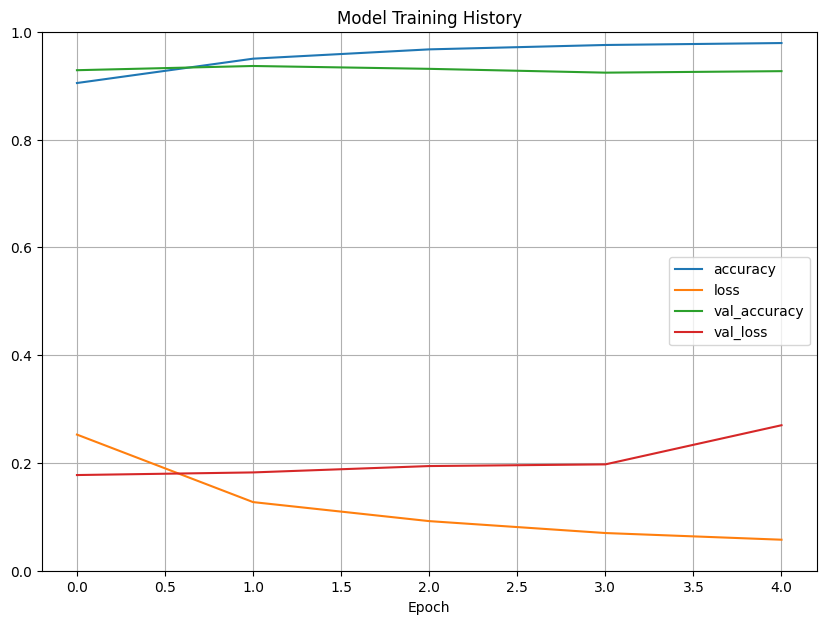

124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step

--- Classification Report (LSTM Model) ---
              precision    recall  f1-score   support

Negative (0)       0.78      0.54      0.64       478
Postivie (1)       0.94      0.98      0.96      3486

    accuracy                           0.93      3964
   macro avg       0.86      0.76      0.80      3964
weighted avg       0.92      0.93      0.92      3964


--- Confusion Matrix (LSTM Model) ---


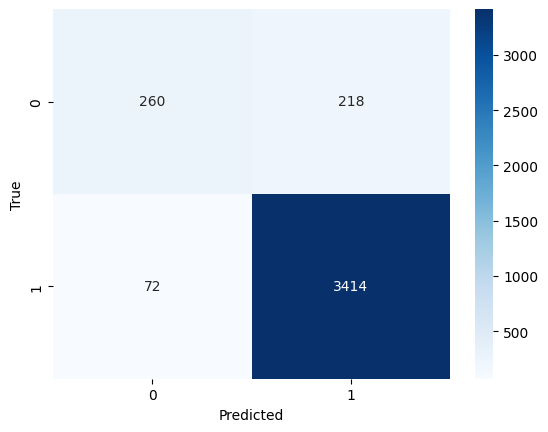

In [19]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.show()

y_pred_lstm_proba = model_lstm.predict(X_test_pad)
y_pred_lstm = (y_pred_lstm_proba>0.5).astype(int)

print("\n--- Classification Report (LSTM Model) ---")
print(classification_report(y_test,y_pred_lstm, target_names=['Negative (0)','Postivie (1)']))

print("\n--- Confusion Matrix (LSTM Model) ---")
cm_lstm = confusion_matrix(y_test,y_pred_lstm)
sns.heatmap(cm_lstm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

documents = df['cleaned_text']

vectorizer_lda = CountVectorizer(max_df = 0.95, min_df=2, stop_words = 'english')
doc_term_matrix = vectorizer_lda.fit_transform(documents)

print("Shape of the Document-Term Matrix:", doc_term_matrix.shape)

Shape of the Document-Term Matrix: (19818, 6939)


In [22]:
from sklearn.decomposition import LatentDirichletAllocation

NUM_TOPICS = 7

print(f"Training LDA model to find {NUM_TOPICS} topics...")
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=42)
lda_model.fit(doc_term_matrix)
print("LDA model training complete!")

Training LDA model to find 7 topics...
LDA model training complete!


In [23]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")

        top_words = [feature_names[i] for i in topic.argsort() [:-num_top_words - 1:-1]]
        print(" ".join(top_words))
    print("\n")

vocab = vectorizer_lda.get_feature_names_out()

display_topics(lda_model, vocab, 10)

Topic #1:
dress love wear fit like look comfortable compliment im perfect
Topic #2:
color size look ordered like online beautiful fit photo blue
Topic #3:
size fit small im dress like petite ordered large waist
Topic #4:
shirt love little cute really like material look fabric wear
Topic #5:
pant fit love jean color pair like perfect im bought
Topic #6:
sweater sale store price wear fit tried size like soft
Topic #7:
great love color wear look perfect fit soft comfortable jean




In [24]:
import pyLDAvis
import pyLDAvis.lda_model

print("Generating LDA visualization...")

panel = pyLDAvis.lda_model.prepare(lda_model,doc_term_matrix,vectorizer_lda, mds='tsne')
print("Done.")

panel

Generating LDA visualization...
Done.


D:\complaint_analysis\venv-py311\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\complaint_analysis\venv-py311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\complaint_analysis\venv-py311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2     -65.559547   2.927296       1        1  28.693195
6       4.973604 -68.379005       2        1  17.972863
0     -50.870110 -53.115181       3        1  12.150282
1      31.298674  28.475996       4        1  11.124238
4      46.070885 -27.599609       5        1  10.699508
3     -24.607203  43.760838       6        1  10.615269
5      -9.707417 -12.312826       7        1   8.744645, topic_info=         Term         Freq        Total Category  logprob  loglift
1759    dress  9670.000000  9670.000000  Default  30.0000  30.0000
5932  sweater  2354.000000  2354.000000  Default  29.0000  29.0000
4159     pant  1832.000000  1832.000000  Default  28.0000  28.0000
5257    shirt  2378.000000  2378.000000  Default  27.0000  27.0000
3095     jean  2393.000000  2393.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...   

In [25]:
import pickle
import os

ARTIFACTS_DIR = '../artifacts'
if not os.path.exists(ARTIFACTS_DIR):
    os.makedirs(ARTIFACTS_DIR)

with open(os.path.join(ARTIFACTS_DIR, 'tokenizer.pkl'),'wb') as f:
    pickle.dump(tokenizer,f)

model_lstm.save(os.path.join(ARTIFACTS_DIR,'sentiment_model.h5'))
print("Tokenizer and Model have been saved to the 'artifacts' directory!")

Tokenizer and Model have been saved to the 'artifacts' directory!
